In [49]:
%cd drive/MyDrive/PV_Panel_Installation/efficient-kan/src/

[Errno 2] No such file or directory: 'drive/MyDrive/PV_Panel_Installation/efficient-kan/src/'
/content/drive/MyDrive/PV_Panel_Installation


In [ ]:
#!git clone https://github.com/Blealtan/efficient-kan/src/efficient_kan.git

In [ ]:
#!pip install torchinfo

In [71]:
from efficient_kan import KAN

# Train on MNIST
import torch
from tqdm import tqdm
import pandas as pd
import torch
from torch import optim
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import MSELoss
from torch import nn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [72]:
%cd ../../

[Errno 2] No such file or directory: 'MyDrive/PV_Panel_Installation/'
/content/drive/MyDrive/PV_Panel_Installation


# Data Preprocessing

In [74]:
df = pd.read_csv('DeepSolar.csv')

In [75]:
selected_columns = [
'net_metering',
'feedin_tariff',
'rebate',
'property_tax',
'sales_tax',
'cooperate_tax',
'avg_electricity_retail_rate',
'average_household_size',
'housing_unit_median_gross_rent',
'housing_unit_median_value',
'average_household_income',
'number_of_years_of_education',
'gini_index',
'population_density',
'poverty_family_below_poverty_level_rate',
'employ_rate',
'race_asian_rate',
'race_black_africa_rate',
'race_white_rate',
'race_indian_alaska_rate',
'race_islander_rate',
'race_two_more_rate',
'diversity',
'heating_fuel_coal_coke_rate',
'heating_fuel_electricity_rate',
'heating_fuel_solar_rate',
'heating_fuel_fuel_oil_kerosene_rate',
'heating_fuel_gas_rate',
'heating_fuel_none_rate',
'education_less_than_high_school_rate',
'education_high_school_graduate_rate',
'education_college_rate',
'education_bachelor_rate',
'education_master_rate',
'education_professional_school_rate',
'education_doctoral_rate',
'age_median',
'age_5_9_rate',
'age_10_14_rate',
'age_15_17_rate',
'age_18_24_rate',
'age_25_34_rate',
'age_35_44_rate',
'age_45_54_rate',
'age_55_64_rate',
'age_65_74_rate',
'age_75_84_rate',
'age_more_than_85_rate',
'household_type_family_rate',
'dropout_16_19_inschool_rate',
'occupation_construction_rate',
'occupation_public_rate',
'occupation_information_rate',
'occupation_finance_rate',
'occupation_education_rate',
'occupation_administrative_rate',
'occupation_manufacturing_rate',
'occupation_wholesale_rate',
'occupation_retail_rate',
'occupation_transportation_rate',
'occupation_arts_rate',
'occupation_agriculture_rate',
'occupancy_vacant_rate',
'occupancy_owner_rate',
'mortgage_with_rate',
'transportation_home_rate',
'transportation_car_alone_rate',
'transportation_walk_rate',
'transportation_carpool_rate',
'transportation_motorcycle_rate',
'transportation_bicycle_rate',
'transportation_public_rate',
'travel_time_less_than_10_rate',
'travel_time_10_19_rate',
'travel_time_20_29_rate',
'travel_time_30_39_rate',
'travel_time_40_59_rate',
'travel_time_60_89_rate',
'health_insurance_public_rate',
'health_insurance_none_rate',
'travel_time_average',
'voting_2016_dem_percentage',
'voting_2016_gop_percentage',
'air_temperature',
'relative_humidity',
'daily_solar_radiation',
'atmospheric_pressure',
'wind_speed',
'earth_temperature',
'elevation',
'earth_temperature_amplitude',
'frost_days',
'heating_degree_days',
'cooling_degree_days',
'solar_system_count'
]

In [ ]:
# selected_index = [85,
#  10,
#  48,
#  13,
#  63,
#  25,
#  91,
#  64,
#  45,
#  37,
#  81,
#  82,
#  51,
#  38,
#  27,
#  9,
#  8,
#  65,
#  79,
#  84,
#  94]

In [7]:
len(selected_columns)

95

In [53]:
# prompt: fill missing data with mean
df_model = df[selected_columns]
# Assuming your DataFrame is named 'df' and you want to fill missing values with the mean for all columns.
df_model.fillna(df_model.mean(), inplace=True)

<ipython-input-53-0f8b10cbd773>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.fillna(df_model.mean(), inplace=True)


In [76]:
df_model = df[selected_columns]

In [77]:
# prompt: fill na with KNN

from sklearn.impute import KNNImputer

# Create a KNNImputer object
imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors

# Fit and transform the data to fill missing values using KNN
df_model_filled = pd.DataFrame(imputer.fit_transform(df_model), columns=df_model.columns)

# Now df_model_filled contains the DataFrame with missing values filled using KNN

In [78]:
df_model=df_model_filled.sample(frac = 1, random_state=1234).reset_index(drop=True)

In [33]:
df_model = df[selected_columns].dropna()
#df_model = df_model.iloc[:, selected_index]
df_model_installed = df_model[df_model['solar_system_count'] > 0]

In [10]:
len(df_model)

72537

In [34]:
df_model=df_model_installed.sample(frac = 1, random_state=1234).reset_index(drop=True)

In [79]:
x = df_model.iloc[:, :-1]
y = df_model.iloc[:, -1]
x_train_r, x_test, y_train_r, y_test = train_test_split(x, y, train_size=0.9, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train_r, y_train_r, train_size=5/6, shuffle=False)
Y_mean = y_train.mean()
Y_std = y_train.std()
y_train = (y_train-Y_mean)/Y_std
y_val = (y_val-Y_mean)/Y_std
y_test = (y_test-Y_mean)/Y_std
preprocessing = StandardScaler().fit(
    x_train
)

# x_train = preprocessing.transform(x_train)
# x_val = preprocessing.transform(x_val)
# x_test = preprocessing.transform(x_test)
#x_train_new = np.append(x_train, x_val, axis=0)
#y_train_new = np.append(y_train, y_val)

In [80]:
pd.DataFrame(x_train).describe()

net_metering  feedin_tariff        rebate  property_tax     sales_tax  \
count  54402.000000   54402.000000  54402.000000  54402.000000  54402.000000   
mean      14.088931       1.237326      2.040771     17.709294      5.685453   
std        8.654146       3.166712      3.945069     16.308680      9.749069   
min        0.000000       0.000000      0.000000      0.000000      0.000000   
25%        9.000000       0.000000      0.000000      0.000000      0.000000   
50%       14.000000       0.000000      0.000000     11.000000      0.000000   
75%       20.000000       0.000000      0.000000     38.000000     10.000000   
max       35.000000      11.000000     14.000000     42.000000     40.000000   

       cooperate_tax  avg_electricity_retail_rate  average_household_size  \
count   54402.000000                 54402.000000            54402.000000   
mean        0.424672                    10.766564                2.654122   
std         2.311244                     2.560427                0.504632   
min         0.000000                     7.250000                1.090000   
25%         0.000000                     8.970000                2.340000   
50%         0.000000                     9.660000                2.590000   
75%         0.000000                    12.390000                2.890000   
max        16.000000                    16.650000               11.000000   

       housing_unit_median_gross_rent  housing_unit_median_value  ...  \
count                    54402.000000               5.440200e+04  ...   
mean                      1009.565806               2.235012e+05  ...   
std                        432.354805               1.939155e+05  ...   
min                        111.000000               9.999000e+03  ...   
25%                        707.000000               1.045000e+05  ...   
50%                        899.000000               1.627000e+05  ...   
75%                       1197.000000               2.748000e+05  ...   
max                       3501.000000               2.000001e+06  ...   

       relative_humidity  daily_solar_radiation  atmospheric_pressure  \
count       54402.000000           54402.000000          54402.000000   
mean            0.645822               4.246280             97.845892   
std             0.091532               0.541758              4.507028   
min             0.328000               3.300000             73.800000   
25%             0.645000               3.790000             97.500000   
50%             0.674000               4.110000             98.900000   
75%             0.695400               4.570000            100.200000   
max             0.802000               5.680000            101.800000   

         wind_speed  earth_temperature     elevation  \
count  54402.000000       54402.000000  54402.000000   
mean       4.144729          13.969593    336.659237   
std        0.606165           4.855342    411.045434   
min        2.800000           2.200000      1.000000   
25%        3.700000          10.100000    124.000000   
50%        4.200000          13.000000    231.000000   
75%        4.600000          17.800000    357.000000   
max        6.600000          26.600000   2676.000000   

       earth_temperature_amplitude    frost_days  heating_degree_days  \
count                 54402.000000  54402.000000         54402.000000   
mean                     18.007998     65.800004          2367.231330   
std                       4.367004     48.976650          1212.060003   
min                       1.670000      0.000000             9.000000   
25%                      15.590000     17.000000          1304.000000   
50%                      18.910000     67.000000          2527.000000   
75%                      21.100000    104.000000          3310.000000   
max                      28.040000    207.000000          5818.000000   

       cooling_degree_days  
count         54402.000000  
mean           2328.653627  
std             938.443883

In [ ]:
# pf = PolynomialFeatures(degree = 2)
# x_train_pf = pf.fit_transform(x_train)
# x_val_pf = pf.fit_transform(x_val)
# x_test_pf = pf.fit_transform(x_test)

In [56]:
print(len(x_train), len(x_val), len(x_test))

54402 10881 7254


In [81]:
train_dataset = torch.utils.data.TensorDataset(torch.as_tensor(x_train.values, dtype=torch.float32),torch.as_tensor(y_train.values, dtype=torch.float32))
val_dataset = torch.utils.data.TensorDataset(torch.as_tensor(x_val.values, dtype=torch.float32),torch.as_tensor(y_val.values, dtype=torch.float32))
test_dataset = torch.utils.data.TensorDataset(torch.as_tensor(x_test.values, dtype=torch.float32),torch.as_tensor(y_test.values, dtype=torch.float32))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

In [ ]:
#train_dataset = torch.utils.data.TensorDataset(torch.as_tensor(
#                     df_model_installed.iloc[:int(0.75*len(df_model_installed)),:].iloc[:, :-1].values, dtype=torch.float32),
#                     torch.as_tensor(df_model_installed.iloc[:int(0.75*len(df_model_installed)),:].iloc[:, -1].values, dtype=torch.float32))
#val_dataset = torch.utils.data.TensorDataset(torch.as_tensor(
#                     df_model_installed.iloc[int(0.75*len(df_model_installed)):int(0.9*len(df_model_installed)),:].iloc[:, :-1].values, dtype=torch.float32),
#                     torch.as_tensor(df_model_installed.iloc[int(0.75*len(df_model_installed)):int(0.9*len(df_model_installed)),:].iloc[:, -1].values, dtype=torch.float32))
#test_dataset = torch.utils.data.TensorDataset(torch.as_tensor(
#                     df_model_installed.iloc[int(0.9*len(df_model_installed)):,:].iloc[:, :-1].values, dtype=torch.float32),
#                     torch.as_tensor(df_model_installed.iloc[int(0.9*len(df_model_installed)):,:].iloc[:, -1].values, dtype=torch.float32))

# preprocessing = StandardScaler().fit(
#     train_dataset.tensors[0]
# )

# Y_mean = train_dataset.tensors[1].mean().item()
# Y_std = train_dataset.tensors[1].std().item()

# import torch
# from sklearn.preprocessing import StandardScaler

# # Assuming 'preprocessing' is your fitted StandardScaler
# for i in range(len(train_dataset.tensors[0])):
#     # Convert the tensor to a NumPy array, transform, and convert back to a tensor
#     transformed_data = preprocessing.transform(train_dataset.tensors[0][i].numpy().reshape(1, -1))
#     train_dataset.tensors[0][i] = torch.tensor(transformed_data, dtype=torch.float32).squeeze()  # Squeeze to remove extra dimension

# # Repeat the process for val_dataset and test_dataset
# for i in range(len(val_dataset.tensors[0])):
#     transformed_data = preprocessing.transform(val_dataset.tensors[0][i].numpy().reshape(1, -1))
#     val_dataset.tensors[0][i] = torch.tensor(transformed_data, dtype=torch.float32).squeeze()

# for i in range(len(test_dataset.tensors[0])):
#     transformed_data = preprocessing.transform(test_dataset.tensors[0][i].numpy().reshape(1, -1))
#     test_dataset.tensors[0][i] = torch.tensor(transformed_data, dtype=torch.float32).squeeze()

# for i in range(len(train_dataset.tensors[1])):
#   train_dataset.tensors[1][i]= (train_dataset.tensors[1][i] - Y_mean) / Y_std

# for i in range(len(val_dataset.tensors[1])):
#   val_dataset.tensors[1][i]= (val_dataset.tensors[1][i] - Y_mean) / Y_std

# for i in range(len(test_dataset.tensors[1])):
#   test_dataset.tensors[1][i]= (test_dataset.tensors[1][i] - Y_mean) / Y_std

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=True)

# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

In [82]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

54402
10881
7254


In [14]:
test_dataset.tensors[0].shape

torch.Size([7254, 94])

# KAN

### Model and Training

In [ ]:
# Define model
model = KAN([94, 10, 1], grid_size = 5, spline_order=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Define optimizer
optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
# Define loss
criterion = nn.MSELoss()

In [ ]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)
# count_parameters(model)

In [ ]:
from torchinfo import summary

  # Assuming RegressionNet is your model
input_size = (128, 94)  # Change according to your model's input size (batch_size, input_dimensions)

summary_info = summary(model, input_size=input_size, dtypes=[torch.float32], verbose=0, col_names=["output_size", "num_params", "mult_adds"])

print(summary_info)

Layer (type:depth-idx)                   Output Shape              Param #                   Mult-Adds
KAN                                      [128, 1]                  --                        --
├─ModuleList: 1-1                        --                        --                        --
│    └─KANLinear: 2-1                    [128, 10]                 9,400                     --
│    │    └─SiLU: 3-1                    [128, 94]                 --                        --
│    └─KANLinear: 2-2                    [128, 1]                  100                       --
│    │    └─SiLU: 3-2                    [128, 10]                 --                        --
Total params: 9,500
Trainable params: 9,500
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.05
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.05


In [ ]:
train_loss = []
validation_loss = []

for epoch in range(20):
    # trainning
    start_time = time.time()
    total_loss = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.cuda(), target.cuda()
        out = model(x)
        loss = criterion(out, target)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_loader)
    train_loss.append(avg_loss)
    print(f'==>>> epoch: {epoch+1}, train loss: {avg_loss:.6f}')
    print(f'Epoch {epoch + 1}, Current Memory: {torch.cuda.memory_allocated() / 1e6} MB')
    print(f'Peak Memory: {torch.cuda.max_memory_allocated() / 1e6} MB')
    # evaluating
    with torch.no_grad():

      total_loss = 0
      for batch_idx, (x, target) in enumerate(val_loader):
          x, target = x.cuda(), target.cuda()
          out = model(x)
          val_loss = criterion(out, target)
          total_loss += val_loss.item()
      avg_loss = total_loss / len(val_loader)
      validation_loss.append(avg_loss)
      end_time = time.time()
      print(f'==>>> epoch: {epoch+1}, val loss: {avg_loss:.6f}')
      print(f'Epoch {epoch + 1}, Current Memory: {torch.cuda.memory_allocated() / 1e6} MB')
      print(f'Peak Memory: {torch.cuda.max_memory_allocated() / 1e6} MB')
      print('=======================================================')
      print(f'Time spent at each epoch: {end_time - start_time}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([85])) that is different to the input size (torch.Size([85, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([69])) that is different to the input size (torch.Size([69, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

==>>> epoch: 1, train loss: 1.000248
Epoch 1, Current Memory: 800.70144 MB
Peak Memory: 4799.843328 MB
==>>> epoch: 1, val loss: 1.114742
Epoch 1, Current Memory: 800.695296 MB
Peak Memory: 4799.843328 MB
Time spent at each epoch: 1.6176469326019287
==>>> epoch: 2, train loss: 1.000454
Epoch 2, Current Memory: 800.70144 MB
Peak Memory: 4799.843328 MB
==>>> epoch: 2, val loss: 1.111323
Epoch 2, Current Memory: 800.695296 MB
Peak Memory: 4799.843328 MB
Time spent at each epoch: 1.6005878448486328
==>>> epoch: 3, train loss: 1.000997
Epoch 3, Current Memory: 800.70144 MB
Peak Memory: 4799.843328 MB
==>>> epoch: 3, val loss: 1.107929
Epoch 3, Current Memory: 800.695296 MB
Peak Memory: 4799.843328 MB
Time spent at each epoch: 1.6179325580596924
==>>> epoch: 4, train loss: 0.999488
Epoch 4, Current Memory: 800.70144 MB
Peak Memory: 4799.843328 MB
==>>> epoch: 4, val loss: 1.108636
Epoch 4, Current Memory: 800.714752 MB
Peak Memory: 4799.843328 MB
Time spent at each epoch: 1.6380784511566162


### Results

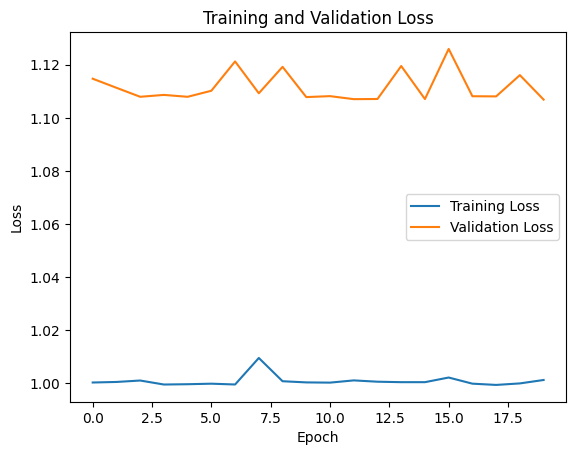

In [ ]:
# Plot the training loss and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
ssq = torch.nn.MSELoss(reduction = 'sum')

In [ ]:
running_loss_train = 0.0
with torch.no_grad():
    for element, (x, target) in enumerate(train_loader):
        x, target = x.cuda(), target.cuda()
        out = model(x)
        loss = ssq(out, target.reshape(target.shape[0],1))
        running_loss_train += loss.item()
    mse = running_loss_train/len(train_loader.sampler)
print("Loss: %.6f \t RMSE: %.6f"%(mse,mse**0.5))

Loss: 0.999058 	 RMSE: 0.999529


In [ ]:
running_loss_val = 0.0
with torch.no_grad():
    for element, (x, target) in enumerate(val_loader):
        x, target = x.cuda(), target.cuda()
        out = model(x)
        loss = ssq(out, target.reshape(target.shape[0],1))
        running_loss_val += loss.item()
    mse = running_loss_val/len(val_loader.sampler)
print("Loss: %.6f \t RMSE: %.6f"%(mse,mse**0.5))

Loss: 1.111332 	 RMSE: 1.054197


In [ ]:
running_loss_test = 0.0
with torch.no_grad():
    for element, (x, target) in enumerate(test_loader):
        x, target = x.cuda(), target.cuda()
        out = model(x)
        loss = ssq(out, target.reshape(target.shape[0],1))
        running_loss_test += loss.item()
    mse = running_loss_test/len(test_loader.sampler)
print("Loss: %.6f \t RMSE: %.6f"%(mse,mse**0.5))

Loss: 1.212879 	 RMSE: 1.101308


In [ ]:
with torch.no_grad():
    outputs = model(test_dataset.tensors[0].cuda())
    print(outputs)

tensor([[-0.0021],
        [ 0.0025],
        [ 0.0053],
        ...,
        [ 0.0006],
        [-0.0012],
        [ 0.0009]], device='cuda:0')


In [ ]:
preds = outputs.detach().cpu().numpy().reshape(-1,1)
targets = test_dataset.tensors[1].detach().cpu().numpy().reshape(-1,1)

In [ ]:
print(f'MSE: {mean_squared_error(targets, preds):.4f} and R2: {r2_score(targets, preds):.4f}')

MSE: 1.2129 and R2: 0.0007


# MLP

### Model and Training

In [83]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(94, 256)
    self.fc2 = nn.Linear(256, 1024)
    self.fc3 = nn.Linear(1024, 512)
    self.fc4 = nn.Linear(512, 256)
    self.fc5 = nn.Linear(256, 128)
    self.fc6 = nn.Linear(128, 1)
    self.do1 = nn.Dropout(0.5)
    self.do2 = nn.Dropout(0.5)
    self.do3 = nn.Dropout(0.5)
    self.do4 = nn.Dropout(0.5)
    self.do5 = nn.Dropout(0.5)
    self.bn1 = nn.BatchNorm1d(256)
    self.bn2 = nn.BatchNorm1d(1024)
    self.bn3 = nn.BatchNorm1d(512)
    self.bn4 = nn.BatchNorm1d(256)
    self.bn5 = nn.BatchNorm1d(128)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.bn1(x)
    x = self.fc2(x)
    x = self.bn2(x)
    x = self.relu(self.fc3(x))
    x = self.bn3(x)
    x = self.relu(self.fc4(x))
    x = self.bn4(x)
    x = self.relu(self.fc5(x))
    x = self.bn5(x)
    x = self.do5(x)
    x = self.fc6(x)
    # x = self.relu(self.fc3(x))
    # x = self.relu(self.fc4(x))
    # x = self.fc5(x)
    return x

In [84]:
model = Net()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = MSELoss()
epochs = 20

In [ ]:
# input_size = (128, 94)  # Change according to your model's input size (batch_size, input_dimensions)

# summary_info = summary(model, input_size=input_size, dtypes=[torch.float32], verbose=0, col_names=["output_size", "num_params", "mult_adds"])

# print(summary_info)

In [85]:
train_loss = []
validation_loss = []

for epoch in range(epochs):
    model.train()
    # trainning
    start_time = time.time()
    total_loss = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.to(device), target.to(device)
        out = model(x)
        loss = criterion(out, target)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_loader)
    train_loss.append(avg_loss)
    print(f'==>>> epoch: {epoch+1}, train loss: {avg_loss:.6f}')
    print(f'Epoch {epoch + 1}, Current Memory: {torch.cuda.memory_allocated() / 1e6} MB')
    print(f'Peak Memory: {torch.cuda.max_memory_allocated() / 1e6} MB')

    # evaluating
    with torch.no_grad():
      model.eval()
      total_loss = 0
      for batch_idx, (x, target) in enumerate(val_loader):
          x, target = x.to(device), target.to(device)
          out = model(x)
          val_loss = criterion(out, target)
          total_loss += val_loss.item()
      avg_loss = total_loss / len(val_loader)
      validation_loss.append(avg_loss)
      end_time = time.time()
      print(f'==>>> epoch: {epoch+1}, val loss: {avg_loss:.6f}')
      print(f'Epoch {epoch + 1}, Current Memory: {torch.cuda.memory_allocated() / 1e6} MB')
      print(f'Peak Memory: {torch.cuda.max_memory_allocated() / 1e6} MB')
      print('=======================================================')
      print(f'Time spent at each epoch: {end_time - start_time}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

==>>> epoch: 1, train loss: 1.065006
Epoch 1, Current Memory: 40.77312 MB
Peak Memory: 102.843904 MB
==>>> epoch: 1, val loss: 20.037070
Epoch 1, Current Memory: 40.772608 MB
Peak Memory: 102.843904 MB
Time spent at each epoch: 2.062241315841675
==>>> epoch: 2, train loss: 0.998793
Epoch 2, Current Memory: 40.77312 MB
Peak Memory: 102.843904 MB
==>>> epoch: 2, val loss: 2.169857
Epoch 2, Current Memory: 40.772608 MB
Peak Memory: 102.843904 MB
Time spent at each epoch: 1.9190397262573242
==>>> epoch: 3, train loss: 0.998606
Epoch 3, Current Memory: 40.77312 MB
Peak Memory: 102.843904 MB
==>>> epoch: 3, val loss: 1.390819
Epoch 3, Current Memory: 40.772608 MB
Peak Memory: 102.843904 MB
Time spent at each epoch: 1.9267704486846924
==>>> epoch: 4, train loss: 0.998217
Epoch 4, Current Memory: 40.77312 MB
Peak Memory: 102.843904 MB
==>>> epoch: 4, val loss: 3.673210
Epoch 4, Current Memory: 40.772608 MB
Peak Memory: 102.843904 MB
Time spent at each epoch: 1.9734995365142822
==>>> epoch: 5, 

### Results

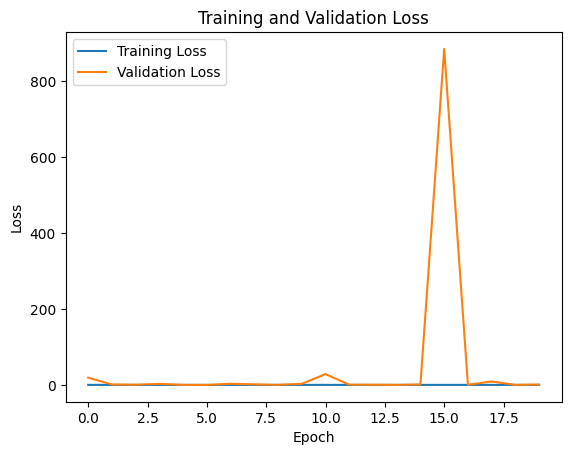

In [86]:
# Plot the training loss and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [87]:
ssq = torch.nn.MSELoss(reduction = 'sum')

In [88]:
running_loss_train = 0.0
with torch.no_grad():
    for element, (x, target) in enumerate(train_loader):
        x, target = x.cuda(), target.cuda()
        out = model(x)
        loss = ssq(out, target.reshape(target.shape[0],1))
        running_loss_train += loss.item()
    mse = running_loss_train/len(train_loader.dataset)
print("Loss: %.6f \t RMSE: %.6f"%(mse,mse**0.5))

Loss: 1.072133 	 RMSE: 1.035439


In [89]:
running_loss_val = 0.0
with torch.no_grad():
    for element, (x, target) in enumerate(val_loader):
        x, target = x.cuda(), target.cuda()
        out = model(x)
        loss = ssq(out, target.reshape(target.shape[0],1))
        running_loss_val += loss.item()
    mse = running_loss_val/len(val_loader.dataset)
print("Loss: %.6f \t RMSE: %.6f"%(mse,mse**0.5))

Loss: 1.909178 	 RMSE: 1.381730


In [90]:
running_loss_test = 0.0
with torch.no_grad():
    for element, (x, target) in enumerate(test_loader):
        x, target = x.cuda(), target.cuda()
        out = model(x)
        loss = ssq(out, target.reshape(target.shape[0],1))
        running_loss_test += loss.item()
    mse = running_loss_test/len(test_loader.dataset)
print("Loss: %.6f \t RMSE: %.6f"%(mse,mse**0.5))

Loss: 1.390003 	 RMSE: 1.178984


In [91]:
with torch.no_grad():
    outputs = model(test_dataset.tensors[0].cuda())
    print(outputs)

tensor([[ 0.0010],
        [ 0.0034],
        [-0.0024],
        ...,
        [ 0.0011],
        [ 0.0043],
        [ 0.0012]], device='cuda:0')


In [92]:
preds = outputs.detach().cpu().numpy().reshape(-1,1)
targets = test_dataset.tensors[1].detach().cpu().numpy().reshape(-1,1)

In [93]:
print(f'MSE: {mean_squared_error(targets, preds):.4f} and R2: {r2_score(targets, preds):.4f}')

MSE: 1.3900 and R2: -0.0838


In [94]:
torch.save(model, 'mlp_fill_na_knn_model.pth')